# LGBM Model

The winning solution uses combination of four models and lgbm is one of the model. I will start by looking at this solution. 

[Winning Solution](https://www.kaggle.com/c/favorita-grocery-sales-forecasting/discussion/47582#latest-605356)


In [1]:
"""
This is an upgraded version of Ceshine's LGBM starter script, simply adding more
average features and weekly average features on it.
"""
from datetime import date, timedelta
import gc
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

import lightgbm as lgb

In [2]:
data_dir = '/media/farmshare2/Research/raza/p_data/'

In [10]:
class readDataStore():
    """
    This module is to read the data from data store.
    
    In our case, our date store is local and is in .csv format
    """
    
    def __init__(self, data_dir):
        
        self.data_dir = data_dir
    
    def read_stores(self, file_name):
        
        df = pd.read_csv(self.data_dir + file_name)
        
        return df
    
    def read_items(self, file_name):
        
        df = pd.read_csv(self.data_dir + file_name)
        
        return df
    
    def read_transactions(self, file_name):
        
        df = pd.read_csv(self.data_dir + file_name)
        
        return df
    
    def read_oil(self, file_name):
        
        df = pd.read_csv(self.data_dir + file_name)
        
        return df
    
    def read_holidays(self, file_name):
        
        df = pd.read_csv(self.data_dir + file_name)
        
        return df
    
    def read_train(self, file_name):
        
        df = pd.read_csv(self.data_dir + file_name)
        
        return df
    
    def read_test(self, file_name):
        
        df = pd.read_csv(self.data_dir + file_name)
        
        return df
    
    def read_train(self, file_name):
        
        df = pd.read_csv(self.data_dir + file_name)
        
        return df
    
        
        

readDataStore = readDataStore(data_dir)

In [6]:
df_train_raw = pd.read_csv(data_dir+'train.csv')

/home/researcher/Raza/pycharm_projects/tmp/retail-sales-prediction/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
del df_train_raw

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
125497035,125497035,2017-08-15,54,2089339,4.0,False
125497036,125497036,2017-08-15,54,2106464,1.0,True
125497037,125497037,2017-08-15,54,2110456,192.0,False
125497038,125497038,2017-08-15,54,2113914,198.0,True
125497039,125497039,2017-08-15,54,2116416,2.0,False


In [49]:
df_train = pd.read_csv(data_dir+'train.csv', 
                       usecols=[1, 2, 3, 4, 5],
                        dtype={'onpromotion': bool},
                        converters={'unit_sales': lambda u: np.log1p(
                            float(u)) if float(u) > 0 else 0},
                        parse_dates=["date"],
                        skiprows=range(1, 66458909)  # 2016-01-01
                    )


In [50]:
df_test = pd.read_csv(data_dir + "test.csv", usecols=[0, 1, 2, 3, 4],
                        dtype={'onpromotion': bool},
                        parse_dates=["date"]  # , date_parser=parser
                    ).set_index(
                        ['store_nbr', 'item_nbr', 'date']
                    )

In [51]:
# Read the items data frame
df_items = readDataStore.read_items('items.csv').set_index("item_nbr")

# Read the stores data frame
df_stores = readDataStore.read_items('stores.csv').set_index("store_nbr")

# Assiging the values to the labels
le = LabelEncoder()
df_items['family'] = le.fit_transform(df_items['family'].values)

df_stores['city'] = le.fit_transform(df_stores['city'].values)
df_stores['state'] = le.fit_transform(df_stores['state'].values)
df_stores['type'] = le.fit_transform(df_stores['type'].values)

items = df_items.copy()
stores = df_stores.copy()

In [52]:
# Extracting the training data for 2017 until 2017-08-14
df_2017 = df_train.loc[df_train.date>=pd.datetime(2017,1,1)]

# Delete the big training data
# del df_train

# On each store what items are on promotion on each day
promo_2017_train = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["onpromotion"]].unstack(
        level=-1).fillna(False)

Training data fro 2017 consists of 23 billions records an dit covers only 8.5 months. This problem becomes complex and computational expensive if we have to use more data andmore derived features.

In [60]:
promo_2017_train.head()

onpromotion                                              \
date                2017-01-01 2017-01-02 2017-01-03 2017-01-04 2017-01-05   
store_nbr item_nbr                                                           
1         96995          False      False      False      False      False   
          99197          False      False      False      False      False   
          103520         False      False      False      False      False   
          103665         False      False      False      False      False   
          105574         False      False       True      False      False   

                                                                           \
date               2017-01-06 2017-01-07 2017-01-08 2017-01-09 2017-01-10   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   
          105574         True      False      False      False      False   

                    ...                                              \
date                ... 2017-08-06 2017-08-07 2017-08-08 2017-08-09   
store_nbr item_nbr  ...                                               
1         96995     ...      False      False      False      False   
          99197     ...      False      False      False      False   
          103520    ...      False      False      False      False   
          103665    ...      False      False      False      False   
          105574    ...      False      False      False      False   

                                                                           \
date               2017-08-10 2017-08-11 2017-08-12 2017-08-13 2017-08-14   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   
          105574        False      False      False      False      False   

                               
date               2017-08-15  
store_nbr item_nbr             
1         96995         False  
          99197         False  
          103520        False  
          103665        False  
          105574        False  

[5 rows x 227 columns]

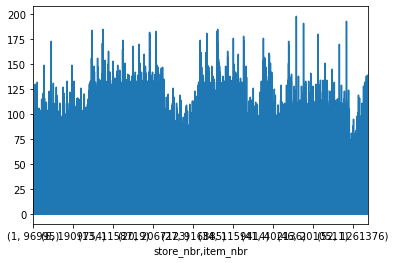

In [55]:
promo_2017_train.sum(axis=1).plot()

In [68]:
promo_2017_train.columns= promo_2017_train.columns.droplevel()

In [61]:
promo_2017_train.columns.get_level_values(1)

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
               '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
               '2017-08-14', '2017-08-15'],
              dtype='datetime64[ns]', name='date', length=227, freq=None)

In [71]:
df_test.head()

id  onpromotion
store_nbr item_nbr date                              
1         96995    2017-08-16  125497040        False
          99197    2017-08-16  125497041        False
          103501   2017-08-16  125497042        False
          103520   2017-08-16  125497043        False
          103665   2017-08-16  125497044        False

In [ ]:
# promotion columns from training data
promo_2017_train.columns = promo_2017_train.columns.get_level_values(1)

In [73]:
# promotion data from test data
promo_2017_test = df_test[["onpromotion"]].unstack(level=-1).fillna(False)

In [77]:
promo_2017_test.head()

onpromotion                                              \
date                2017-08-16 2017-08-17 2017-08-18 2017-08-19 2017-08-20   
store_nbr item_nbr                                                           
1         96995          False      False      False      False      False   
          99197          False      False      False      False      False   
          103501         False      False      False      False      False   
          103520         False      False      False      False      False   
          103665         False      False      False      False      False   

                                                                           \
date               2017-08-21 2017-08-22 2017-08-23 2017-08-24 2017-08-25   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103501        False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   

                                                                           \
date               2017-08-26 2017-08-27 2017-08-28 2017-08-29 2017-08-30   
store_nbr item_nbr                                                          
1         96995         False      False      False      False      False   
          99197         False      False      False      False      False   
          103501        False      False      False      False      False   
          103520        False      False      False      False      False   
          103665        False      False      False      False      False   

                               
date               2017-08-31  
store_nbr item_nbr             
1         96995         False  
          99197         False  
          103501        False  
          103520        False  
          103665        False

Test data Strats from 2017-08-16 to 2017-08-31

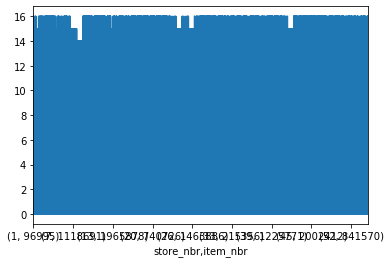

In [76]:
promo_2017_test.sum(axis=1).plot()

In [78]:
promo_2017_test.columns = promo_2017_test.columns.get_level_values(1)

promo_2017_test = promo_2017_test.reindex(promo_2017_train.index).fillna(False)

In [82]:
promo_2017_test.head()

date                2017-08-16  2017-08-17  2017-08-18  2017-08-19  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-08-20  2017-08-21  2017-08-22  2017-08-23  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-08-24  2017-08-25  2017-08-26  2017-08-27  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                  
1         96995          False       False       False       False  
          99197          False       False       False       False  
          103520         False       False       False       False  
          103665         False       False       False       False  
          105574         False       False       False       False

In [83]:
promo_2017_train.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False        True       False   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False        True       False       False   

date                2017-01-09  2017-01-10  ...  2017-08-06  2017-08-07  \
store_nbr item_nbr                          ...                           
1         96995          False       False  ...       False       False   
          99197          False       False  ...       False       False   
          103520         False       False  ...       False       False   
          103665         False       False  ...       False       False   
          105574         False       False  ...       False       False   

date                2017-08-08  2017-08-09  2017-08-10  2017-08-11  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                  
1         96995          False       False       False       False  
          99197          False       False       False       False  
          103520         False       False       False       False  
          103665         False       False       False       False  
          105574         False       False       False       False  

[5 rows x 227 columns]

In [ ]:
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)

In [84]:
# Combined the promotion data from training and test data
promo_2017 = pd.concat([promo_2017_train, promo_2017_test], axis=1)

In [85]:
promo_2017.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False        True       False   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False        True       False       False   

date                2017-01-09  2017-01-10  ...  2017-08-22  2017-08-23  \
store_nbr item_nbr                          ...                           
1         96995          False       False  ...       False       False   
          99197          False       False  ...       False       False   
          103520         False       False  ...       False       False   
          103665         False       False  ...       False       False   
          105574         False       False  ...       False       False   

date                2017-08-24  2017-08-25  2017-08-26  2017-08-27  \
store_nbr item_nbr                                                   
1         96995          False       False       False       False   
          99197          False       False       False       False   
          103520         False       False       False       False   
          103665         False       False       False       False   
          105574         False       False       False       False   

date                2017-08-28  2017-08-29  2017-08-30  2017-08-31  
store_nbr item_nbr                                                  
1         96995          False       False       False       False  
          99197          False       False       False       False  
          103520         False       False       False       False  
          103665         False       False       False       False  
          105574         False       False       False       False  

[5 rows x 243 columns]

## Working on Traget Variable: 

In this problem, our traget variable is unit_sales.

In [89]:
df_2017_tmp = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1)

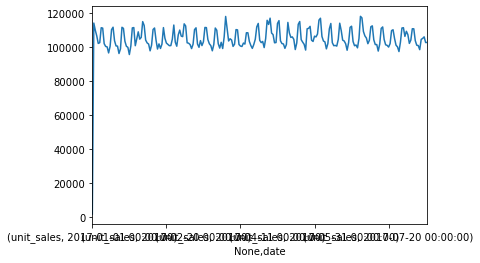

In [93]:
df_2017_tmp.count(axis=0).plot()

There are some missing values for unit sales ascan be seen from above plot. In the solution, they filled with 0, however I am not fully convinced. There could be other method to handle these missing values. One of the argument is that missing values are due to issues with data colllection. 

This issue can be further studied. 

On epotentional candidate to be used for forward filling can be average over last 20 days or so. 

In [ ]:
df_2017 = df_2017.set_index(
    ["store_nbr", "item_nbr", "date"])[["unit_sales"]].unstack(
        level=-1).fillna(0)



df_2017.columns = df_2017.columns.get_level_values(1)

In [98]:
items.head()

,family,class,perishable
item_nbr,,,
96995,12,1093,0
99197,12,1067,0
103501,7,3008,0
103520,12,1028,0
103665,5,2712,1


In [99]:
stores.head()

,city,state,type,cluster
store_nbr,,,,
1,18,12,3,13
2,18,12,3,13
3,18,12,3,8
4,18,12,3,9
5,21,14,3,4


In [100]:
items = items.reindex(df_2017.index.get_level_values(1))
stores = stores.reindex(df_2017.index.get_level_values(0))

In [101]:
items.head()

,family,class,perishable
item_nbr,,,
96995,12,1093,0
99197,12,1067,0
103520,12,1028,0
103665,5,2712,1
105574,12,1045,0


In [102]:
stores.head()

,city,state,type,cluster
store_nbr,,,,
1,18,12,3,13
1,18,12,3,13
1,18,12,3,13
1,18,12,3,13
1,18,12,3,13


In [103]:
df_2017_item = df_2017.groupby('item_nbr')[df_2017.columns].sum()
promo_2017_item = promo_2017.groupby('item_nbr')[promo_2017.columns].sum()

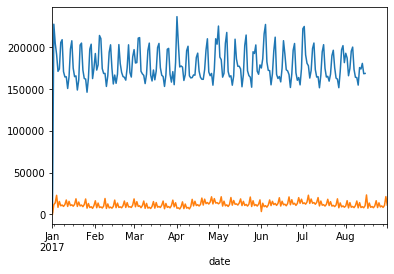

In [109]:
df_2017_item.sum(axis=0).plot()
promo_2017_item.sum(axis=0).plot()

In [110]:
df_2017.head()

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995            0.0    0.000000    0.000000    0.000000   
          99197            0.0    0.000000    1.386294    0.693147   
          103520           0.0    0.693147    1.098612    0.000000   
          103665           0.0    0.000000    0.000000    1.386294   
          105574           0.0    0.000000    1.791759    2.564949   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000    0.000000   
          99197       0.693147    0.693147    1.098612    0.000000   
          103520      1.098612    1.386294    0.693147    0.000000   
          103665      1.098612    1.098612    0.693147    1.098612   
          105574      2.302585    1.945910    1.609438    1.098612   

date                2017-01-09  2017-01-10  ...  2017-08-06  2017-08-07  \
store_nbr item_nbr                          ...                           
1         96995       0.000000    0.000000  ...    1.098612    1.098612   
          99197       0.000000    0.693147  ...    0.000000    1.098612   
          103520      0.693147    0.693147  ...    0.000000    0.000000   
          103665      0.000000    2.079442  ...    0.693147    1.098612   
          105574      1.386294    2.302585  ...    0.000000    1.791759   

date                2017-08-08  2017-08-09  2017-08-10  2017-08-11  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.693147    0.000000   
          99197       0.000000    1.098612    0.000000    0.000000   
          103520      1.386294    0.000000    1.386294    0.693147   
          103665      0.000000    2.079442    2.302585    1.098612   
          105574      2.079442    1.945910    2.397895    1.791759   

date                2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                  
1         96995       0.000000    0.000000    0.000000    0.000000  
          99197       0.000000    0.000000    0.000000    0.000000  
          103520      0.693147    0.693147    0.000000    0.000000  
          103665      0.000000    0.000000    0.693147    0.693147  
          105574      1.791759    0.000000    1.386294    1.609438  

[5 rows x 227 columns]

In [111]:
items.head()

,family,class,perishable
item_nbr,,,
96995,12,1093,0
99197,12,1067,0
103520,12,1028,0
103665,5,2712,1
105574,12,1045,0


In [112]:
df_2017_store_class = df_2017.reset_index()

In [115]:
df_2017_store_class.head()

date,store_nbr,item_nbr,2017-01-01 00:00:00,2017-01-02 00:00:00,2017-01-03 00:00:00,2017-01-04 00:00:00,2017-01-05 00:00:00,2017-01-06 00:00:00,2017-01-07 00:00:00,2017-01-08 00:00:00,...,2017-08-07 00:00:00,2017-08-08 00:00:00,2017-08-09 00:00:00,2017-08-10 00:00:00,2017-08-11 00:00:00,2017-08-12 00:00:00,2017-08-13 00:00:00,2017-08-14 00:00:00,2017-08-15 00:00:00,class
0,1,96995,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.098612,0.000000,0.000000,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,1093
1,1,99197,0.0,0.000000,1.386294,0.693147,0.693147,0.693147,1.098612,0.000000,...,1.098612,0.000000,1.098612,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1067
2,1,103520,0.0,0.693147,1.098612,0.000000,1.098612,1.386294,0.693147,0.000000,...,0.000000,1.386294,0.000000,1.386294,0.693147,0.693147,0.693147,0.000000,0.000000,1028
3,1,103665,0.0,0.000000,0.000000,1.386294,1.098612,1.098612,0.693147,1.098612,...,1.098612,0.000000,2.079442,2.302585,1.098612,0.000000,0.000000,0.693147,0.693147,2712
4,1,105574,0.0,0.000000,1.791759,2.564949,2.302585,1.945910,1.609438,1.098612,...,1.791759,2.079442,1.945910,2.397895,1.791759,1.791759,0.000000,1.386294,1.609438,1045


In [114]:
df_2017_store_class['class'] = items['class'].values

In [116]:

df_2017_store_class_index = df_2017_store_class[['class', 'store_nbr']]
df_2017_store_class = df_2017_store_class.groupby(['class', 'store_nbr'])[df_2017.columns].sum()

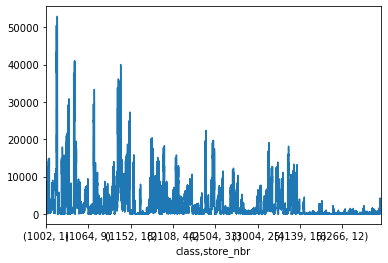

In [118]:
df_2017_store_class.sum(axis=1).plot()

In [119]:
df_2017_promo_store_class = promo_2017.reset_index()
df_2017_promo_store_class['class'] = items['class'].values
df_2017_promo_store_class_index = df_2017_promo_store_class[['class', 'store_nbr']]
df_2017_promo_store_class = df_2017_promo_store_class.groupby(['class', 'store_nbr'])[promo_2017.columns].sum()

In [ ]:
def get_timespan(df, dt, minus, periods, freq='D'):
    
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

In [125]:

def prepare_dataset(df, promo_df, t2017, is_train=True, name_prefix=None):
    X = {
        "promo_14_2017": get_timespan(df = promo_df, dt= t2017, minus=14, periods=14, freq='D').sum(axis=1).values,
        "promo_60_2017": get_timespan(df = promo_df, dt = t2017, minus = 60, periods = 60).sum(axis=1).values,
        "promo_140_2017": get_timespan(df = promo_df, dt = t2017, minus = 140, periods = 140).sum(axis=1).values,
        "promo_3_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 3).sum(axis=1).values,
        "promo_7_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 7).sum(axis=1).values,
        "promo_14_2017_aft": get_timespan(promo_df, t2017 + timedelta(days=16), 15, 14).sum(axis=1).values,
    }

    for i in [3, 7, 14, 30, 60, 140]:
        tmp1 = get_timespan(df, t2017, i, i)
        tmp2 = (get_timespan(promo_df, t2017, i, i) > 0) * 1

        X['has_promo_mean_%s' % i] = (tmp1 * tmp2.replace(0, np.nan)).mean(axis=1).values
        X['has_promo_mean_%s_decay' % i] = (tmp1 * tmp2.replace(0, np.nan) * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values

        X['no_promo_mean_%s' % i] = (tmp1 * (1 - tmp2).replace(0, np.nan)).mean(axis=1).values
        X['no_promo_mean_%s_decay' % i] = (tmp1 * (1 - tmp2).replace(0, np.nan) * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values

    for i in [3, 7, 14, 30, 60, 140]:
        tmp = get_timespan(df, t2017, i, i)
        X['diff_%s_mean' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s' % i] = tmp.mean(axis=1).values
        X['median_%s' % i] = tmp.median(axis=1).values
        X['min_%s' % i] = tmp.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        X['std_%s' % i] = tmp.std(axis=1).values

    for i in [3, 7, 14, 30, 60, 140]:
        tmp = get_timespan(df, t2017 + timedelta(days=-7), i, i)
        X['diff_%s_mean_2' % i] = tmp.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        X['mean_%s_2' % i] = tmp.mean(axis=1).values
        X['median_%s_2' % i] = tmp.median(axis=1).values
        X['min_%s_2' % i] = tmp.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        X['std_%s_2' % i] = tmp.std(axis=1).values

    for i in [7, 14, 30, 60, 140]:
        tmp = get_timespan(df, t2017, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values

        tmp = get_timespan(promo_df, t2017, i, i)
        X['has_promo_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
        X['last_has_promo_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
        X['first_has_promo_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values

    tmp = get_timespan(promo_df, t2017 + timedelta(days=16), 15, 15)
    X['has_promo_days_in_after_15_days'] = (tmp > 0).sum(axis=1).values
    X['last_has_promo_day_in_after_15_days'] = i - ((tmp > 0) * np.arange(15)).max(axis=1).values
    X['first_has_promo_day_in_after_15_days'] = ((tmp > 0) * np.arange(15, 0, -1)).max(axis=1).values

    for i in range(1, 16):
        X['day_%s_2017' % i] = get_timespan(df, t2017, i, 1).values.ravel()

    for i in range(7):
        X['mean_4_dow{}_2017'.format(i)] = get_timespan(df, t2017, 28-i, 4, freq='7D').mean(axis=1).values
        X['mean_20_dow{}_2017'.format(i)] = get_timespan(df, t2017, 140-i, 20, freq='7D').mean(axis=1).values

    for i in range(-16, 16):
        X["promo_{}".format(i)] = promo_df[t2017 + timedelta(days=i)].values.astype(np.uint8)

    X = pd.DataFrame(X)

    if is_train:
        y = df[
            pd.date_range(t2017, periods=16)
        ].values
        return X, y
    if name_prefix is not None:
        X.columns = ['%s_%s' % (name_prefix, c) for c in X.columns]
    return X

print("Preparing dataset...")
t2017 = date(2017, 6, 14)
num_days = 6
X_l, y_l = [], []
for i in range(num_days):
    delta = timedelta(days=7 * i)
    X_tmp, y_tmp = prepare_dataset(df_2017, promo_2017, t2017 + delta)

    X_tmp2 = prepare_dataset(df_2017_item, promo_2017_item, t2017 + delta, is_train=False, name_prefix='item')
    X_tmp2.index = df_2017_item.index
    X_tmp2 = X_tmp2.reindex(df_2017.index.get_level_values(1)).reset_index(drop=True)

    X_tmp3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, t2017 + delta, is_train=False, name_prefix='store_class')
    X_tmp3.index = df_2017_store_class.index
    X_tmp3 = X_tmp3.reindex(df_2017_store_class_index).reset_index(drop=True)

    X_tmp = pd.concat([X_tmp, X_tmp2, X_tmp3, items.reset_index(), stores.reset_index()], axis=1)
    X_l.append(X_tmp)
    y_l.append(y_tmp)

    del X_tmp2
    gc.collect()

Preparing dataset...


In [143]:
X_train = pd.concat(X_l, axis=0)
y_train = np.concatenate(y_l, axis=0)

# del X_l, y_l

# Prepare Validation data set
val_start_date = date(2017, 7, 26)
X_val, y_val = prepare_dataset(df_2017, promo_2017, val_start_date )

X_val2 = prepare_dataset(df_2017_item, promo_2017_item, val_start_date, is_train=False, name_prefix='item')
X_val2.index = df_2017_item.index
X_val2 = X_val2.reindex(df_2017.index.get_level_values(1)).reset_index(drop=True)

X_val3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, val_start_date, is_train=False, name_prefix='store_class')
X_val3.index = df_2017_store_class.index
X_val3 = X_val3.reindex(df_2017_store_class_index).reset_index(drop=True)

X_val = pd.concat([X_val, X_val2, X_val3, items.reset_index(), stores.reset_index()], axis=1)

# Prepare Test data set
test_start_date = date(2017, 8, 16)
X_test = prepare_dataset(df_2017, promo_2017,test_start_date , is_train=False)

X_test2 = prepare_dataset(df_2017_item, promo_2017_item,test_start_date, is_train=False, name_prefix='item')
X_test2.index = df_2017_item.index
X_test2 = X_test2.reindex(df_2017.index.get_level_values(1)).reset_index(drop=True)

X_test3 = prepare_dataset(df_2017_store_class, df_2017_promo_store_class, test_start_date, is_train=False, name_prefix='store_class')
X_test3.index = df_2017_store_class.index
X_test3 = X_test3.reindex(df_2017_store_class_index).reset_index(drop=True)

X_test = pd.concat([X_test, X_test2, X_test3, items.reset_index(), stores.reset_index()], axis=1)

# del X_test2, X_val2, df_2017_item, promo_2017_item, df_2017_store_class, df_2017_promo_store_class, df_2017_store_class_index
gc.collect()

45279

In [144]:
print("Training and predicting models...")
params = {
    'num_leaves': 3,
    'objective': 'regression',
    'min_data_in_leaf': 200,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'metric': 'l2',
    'num_threads': 20
}

MAX_ROUNDS = 200
val_pred = []
test_pred = []
cate_vars = []
for i in range(16):
    print("=" * 50)
    print("Step %d" % (i+1))
    print("=" * 50)
    dtrain = lgb.Dataset(
        X_train, label=y_train[:, i],
        categorical_feature=cate_vars,
        weight=pd.concat([items["perishable"]] * num_days) * 0.25 + 1
    )
    dval = lgb.Dataset(
        X_val, label=y_val[:, i], reference=dtrain,
        weight=items["perishable"] * 0.25 + 1,
        categorical_feature=cate_vars)
    bst = lgb.train(
        params, dtrain, num_boost_round=MAX_ROUNDS,
        valid_sets=[dtrain, dval], early_stopping_rounds=125, verbose_eval=50
    )
    print("\n".join(("%s: %.2f" % x) for x in sorted(
        zip(X_train.columns, bst.feature_importance("gain")),
        key=lambda x: x[1], reverse=True
    )))
    val_pred.append(bst.predict(
        X_val, num_iteration=bst.best_iteration or MAX_ROUNDS))
    test_pred.append(bst.predict(
        X_test, num_iteration=bst.best_iteration or MAX_ROUNDS))

print("Validation mse:", mean_squared_error(
    y_val, np.array(val_pred).transpose()))

weight = items["perishable"] * 0.25 + 1
err = (y_val - np.array(val_pred).transpose())**2
err = err.sum(axis=1) * weight
err = np.sqrt(err.sum() / weight.sum() / 16)
print('nwrmsle = {}'.format(err))

y_val = np.array(val_pred).transpose()
df_preds = pd.DataFrame(
    y_val, index=df_2017.index,
    columns=pd.date_range("2017-07-26", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)
df_preds["unit_sales"] = np.clip(np.expm1(df_preds["unit_sales"]), 0, 1000)
df_preds.reset_index().to_csv('lgb_cv.csv', index=False)





Training and predicting models...
Step 1


/home/researcher/Raza/pycharm_projects/tmp/retail-sales-prediction/venv/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.516811	valid_1's l2: 0.502299
[100]	training's l2: 0.384125	valid_1's l2: 0.375557
[150]	training's l2: 0.3429	valid_1's l2: 0.336831
[200]	training's l2: 0.3282	valid_1's l2: 0.323126
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.3282	valid_1's l2: 0.323126
mean_140_decay: 4024953.10
mean_60_decay: 2922402.25
mean_7_decay: 2619069.54
mean_30_decay: 1141487.40
mean_7: 752724.45
promo_0: 652552.72
mean_14_decay: 602075.80
mean_4_dow0_2017: 520040.69
mean_20_dow0_2017: 508434.13
median_7: 233157.57
day_1_2017: 158488.50
no_promo_mean_140_decay: 116449.29
no_promo_mean_7_decay: 79972.05
no_promo_mean_60_decay: 61348.96
mean_3_decay: 58255.24
last_has_sales_day_in_last_7: 49406.53
no_promo_mean_3_decay: 40563.23
no_promo_mean_3: 37003.33
no_promo_mean_7: 32569.45
min_3: 20231.08
first_has_promo_day_in_last_7: 12477.36
no_promo_mean_14_decay: 7195.39
mean_3: 6496.98
promo_-7: 4916.9

Step 2
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.497177	valid_1's l2: 0.500674
[100]	training's l2: 0.39025	valid_1's l2: 0.397242
[150]	training's l2: 0.35605	valid_1's l2: 0.363741
[200]	training's l2: 0.343303	valid_1's l2: 0.350865
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.343303	valid_1's l2: 0.350865
mean_140_decay: 5711426.42
mean_60_decay: 3222917.47
mean_7: 740104.04
mean_20_dow1_2017: 593289.06
mean_7_decay: 584144.63
median_7: 301114.51
first_has_promo_day_in_after_15_days: 250097.29
mean_30_decay: 185863.30
mean_4_dow1_2017: 128267.69
mean_14_decay: 127422.09
promo_1: 104272.61
no_promo_mean_7_decay: 62091.06
no_promo_mean_60: 61930.29
no_promo_mean_140_decay: 58259.06
no_promo_mean_60_decay: 33230.70
no_promo_mean_30: 23467.94
no_promo_mean_30_decay: 23088.49
no_promo_mean_3: 15714.33
no_promo_mean_7: 15132.44
max_7: 12619.80
no_promo_mean_14_decay: 11079.24
day_1_2017: 10423.20
no_promo_mean_14: 4289.

Step 3
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.542749	valid_1's l2: 0.560948
[100]	training's l2: 0.4122	valid_1's l2: 0.430593
[150]	training's l2: 0.371058	valid_1's l2: 0.388348
[200]	training's l2: 0.356517	valid_1's l2: 0.372993
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.356517	valid_1's l2: 0.372993
mean_140_decay: 5683389.58
mean_60_decay: 2664632.58
mean_4_dow2_2017: 1822269.24
mean_20_dow2_2017: 1448216.37
mean_7: 1299955.13
promo_2: 475208.97
median_7: 284090.63
day_5_2017: 102456.50
no_promo_mean_140_decay: 92599.97
no_promo_mean_7_decay: 78240.83
mean_7_decay: 57718.85
no_promo_mean_60_decay: 51731.68
max_7: 48675.04
mean_14_decay: 48060.34
mean_30_decay: 46934.10
day_4_2017: 19697.47
no_promo_mean_30_decay: 18315.44
no_promo_mean_14_decay: 9997.44
item_promo_2: 6375.34
no_promo_mean_3: 5786.35
no_promo_mean_14: 5747.34
no_promo_mean_7: 4219.06
no_promo_mean_3_decay: 3855.88
promo_14_2017: 0.00
promo_6

Step 4
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.581011	valid_1's l2: 0.579683
[100]	training's l2: 0.437487	valid_1's l2: 0.440767
[150]	training's l2: 0.395517	valid_1's l2: 0.399878
[200]	training's l2: 0.379529	valid_1's l2: 0.38358
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.379529	valid_1's l2: 0.38358
mean_140_decay: 8513778.30
mean_60_decay: 3516261.30
mean_4_dow3_2017: 1380578.00
mean_20_dow3_2017: 1056153.84
mean_7_decay: 504015.19
mean_30_decay: 311155.00
promo_3: 293705.03
mean_7: 231961.16
day_4_2017: 141016.84
day_3_2017: 111749.95
no_promo_mean_60: 85504.30
no_promo_mean_140_decay: 51617.16
no_promo_mean_7_decay: 48700.39
no_promo_mean_60_decay: 28519.33
mean_14_decay: 27843.84
last_has_sales_day_in_last_7: 27369.22
no_promo_mean_30_decay: 21108.51
median_7: 20512.14
max_7: 14924.08
mean_60: 13502.60
median_60: 8251.77
no_promo_mean_14_decay: 7346.00
no_promo_mean_3: 6953.30
no_promo_mean_7: 6777.89
it

Step 5
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.605905	valid_1's l2: 0.606857
[100]	training's l2: 0.452079	valid_1's l2: 0.455028
[150]	training's l2: 0.407148	valid_1's l2: 0.40996
[200]	training's l2: 0.390593	valid_1's l2: 0.392732
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.390593	valid_1's l2: 0.392732
mean_140_decay: 5646488.30
mean_4_dow4_2017: 4075508.11
mean_60_decay: 3718559.10
mean_20_dow4_2017: 1622829.61
mean_7_decay: 667989.18
mean_3: 447653.84
day_3_2017: 318534.82
promo_4: 295080.16
mean_30_decay: 109350.78
day_4_2017: 58792.84
max_3: 38863.80
mean_14_decay: 37756.76
median_3: 36131.20
last_has_sales_day_in_last_7: 33670.08
no_promo_mean_3: 26493.11
no_promo_mean_140_decay: 24822.41
no_promo_mean_30_decay: 21476.09
no_promo_mean_7_decay: 18711.67
no_promo_mean_60_decay: 16185.05
last_has_sales_day_in_last_14: 12475.50
item_day_1_2017: 10014.52
no_promo_mean_14_decay: 8776.35
median_60: 8433.36
media

Step 6
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.554188	valid_1's l2: 0.578878
[100]	training's l2: 0.431414	valid_1's l2: 0.449332
[150]	training's l2: 0.393623	valid_1's l2: 0.407818
[200]	training's l2: 0.37944	valid_1's l2: 0.391281
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.37944	valid_1's l2: 0.391281
mean_140_decay: 7659550.46
mean_60_decay: 3547904.61
mean_20_dow5_2017: 806186.38
mean_3: 359508.66
no_promo_mean_60: 341851.14
promo_5: 331579.77
mean_30_decay: 241104.26
mean_4_dow5_2017: 181654.83
mean_7_decay: 105206.10
mean_3_decay: 90634.45
no_promo_mean_30: 63114.64
median_3: 54353.22
no_promo_mean_140_decay: 53859.56
no_promo_mean_7_decay: 44191.23
median_60: 40599.75
mean_60: 32320.59
no_promo_mean_60_decay: 27110.28
max_3: 25162.00
item_day_2_2017: 18789.85
no_promo_mean_3: 17881.76
no_promo_mean_14_decay: 15272.20
item_min_3: 14032.23
median_7: 9364.49
no_promo_mean_3_decay: 8588.48
no_promo_mean_30_de

Step 7
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.545101	valid_1's l2: 0.66295
[100]	training's l2: 0.423877	valid_1's l2: 0.521274
[150]	training's l2: 0.385185	valid_1's l2: 0.472558
[200]	training's l2: 0.371083	valid_1's l2: 0.452733
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.371083	valid_1's l2: 0.452733
mean_140_decay: 7005747.08
mean_60_decay: 2601353.80
mean_20_dow6_2017: 1245973.98
promo_6: 534475.81
mean_4_dow6_2017: 518004.03
mean_7_decay: 280058.21
mean_30_decay: 238260.60
mean_3_decay: 168962.97
no_promo_mean_60: 152251.39
median_3: 127452.25
no_promo_mean_30: 84882.83
no_promo_mean_140_decay: 82738.55
no_promo_mean_60_decay: 81661.19
no_promo_mean_7_decay: 69255.44
item_day_1_2017: 24549.52
mean_60: 21588.00
mean_3: 18077.87
no_promo_mean_14_decay: 17866.68
day_1_2017: 14209.88
no_promo_mean_7: 12336.37
no_promo_mean_3_decay: 9872.92
median_60: 4618.54
median_7: 4036.00
item_no_promo_mean_3_decay: 3750.

Step 8
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.55153	valid_1's l2: 0.642558
[100]	training's l2: 0.418194	valid_1's l2: 0.49406
[150]	training's l2: 0.376907	valid_1's l2: 0.445058
[200]	training's l2: 0.362418	valid_1's l2: 0.426729
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.362418	valid_1's l2: 0.426729
mean_140_decay: 6281236.70
mean_60_decay: 2697979.70
mean_20_dow0_2017: 992590.67
promo_7: 905454.00
mean_4_dow0_2017: 618864.56
mean_7: 467853.20
median_60: 455175.17
no_promo_mean_60: 328039.37
median_7: 300941.09
no_promo_mean_140_decay: 212814.20
mean_30_decay: 209150.10
no_promo_mean_60_decay: 148571.43
no_promo_mean_30: 121744.17
no_promo_mean_7_decay: 81121.70
mean_7_decay: 41416.71
no_promo_mean_14: 10814.50
no_promo_mean_7: 10713.90
item_no_promo_mean_3_decay: 10032.25
promo_0: 8286.14
mean_20_dow2_2017: 8177.44
no_promo_mean_30_decay: 5551.07
item_day_1_2017: 4327.67
median_3: 3484.68
day_5_2017: 1907.0

Step 9
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.524297	valid_1's l2: 0.572143
[100]	training's l2: 0.415644	valid_1's l2: 0.456628
[150]	training's l2: 0.380406	valid_1's l2: 0.418595
[200]	training's l2: 0.367727	valid_1's l2: 0.403577
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.367727	valid_1's l2: 0.403577
mean_140_decay: 4804137.90
mean_60_decay: 2811531.27
mean_20_dow1_2017: 816484.33
median_60: 740780.62
no_promo_mean_30: 557174.54
promo_8: 537575.68
no_promo_mean_60: 513522.20
median_7: 222716.67
mean_30_decay: 212256.48
mean_4_dow1_2017: 158353.18
no_promo_mean_140_decay: 140435.19
no_promo_mean_60_decay: 60143.41
mean_7: 46582.10
no_promo_mean_7_decay: 30066.96
no_promo_mean_14: 27015.13
mean_20_dow2_2017: 22251.59
mean_7_decay: 18509.62
day_5_2017: 15676.57
no_promo_mean_7: 13965.14
mean_60: 10567.59
item_day_1_2017: 9540.79
max_7: 5546.00
day_6_2017: 3974.29
item_no_promo_mean_3_decay: 2354.22
item_no_pro

Step 10
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.567475	valid_1's l2: 0.590123
[100]	training's l2: 0.437497	valid_1's l2: 0.458843
[150]	training's l2: 0.396419	valid_1's l2: 0.416877
[200]	training's l2: 0.381969	valid_1's l2: 0.401407
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.381969	valid_1's l2: 0.401407
mean_140_decay: 5249136.91
mean_20_dow2_2017: 2154651.33
mean_4_dow2_2017: 1950830.55
mean_60_decay: 1735146.33
promo_9: 644591.97
no_promo_mean_30: 446873.30
mean_7: 259633.82
median_60: 240909.21
median_7: 233664.46
no_promo_mean_140_decay: 231651.01
no_promo_mean_60: 168403.80
day_5_2017: 73825.04
mean_30: 71337.70
mean_30_decay: 57356.14
no_promo_mean_60_decay: 57173.00
no_promo_mean_14: 49160.57
mean_60: 30790.00
no_promo_mean_7_decay: 16792.95
max_7: 16603.43
mean_7_decay: 12034.32
no_promo_mean_7: 11490.40
day_4_2017: 7771.63
item_promo_9: 5376.17
item_day_1_2017: 5001.29
no_promo_mean_30_decay: 4230.81

Step 11
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.607818	valid_1's l2: 0.597879
[100]	training's l2: 0.467318	valid_1's l2: 0.462061
[150]	training's l2: 0.422338	valid_1's l2: 0.420121
[200]	training's l2: 0.406319	valid_1's l2: 0.404729
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.406319	valid_1's l2: 0.404729
mean_140_decay: 6872398.70
mean_60_decay: 2885732.31
mean_4_dow3_2017: 1459707.49
mean_20_dow3_2017: 1317456.87
mean_60: 985757.57
no_promo_mean_60: 634211.54
promo_10: 470360.72
median_60: 171879.38
day_4_2017: 141800.05
mean_7_decay: 135397.36
no_promo_mean_140_decay: 120998.16
no_promo_mean_60_decay: 114135.13
no_promo_mean_30: 110776.19
mean_30_decay: 108602.05
mean_30: 43944.80
mean_7: 41048.66
no_promo_mean_7_decay: 26755.68
median_7: 24102.41
day_3_2017: 15491.37
no_promo_mean_7: 14372.18
item_day_1_2017: 13995.37
no_promo_mean_30_decay: 13902.34
mean_3: 5843.40
item_no_promo_mean_3_decay: 2108.18
promo

Step 12
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.637998	valid_1's l2: 0.62572
[100]	training's l2: 0.484276	valid_1's l2: 0.479631
[150]	training's l2: 0.437162	valid_1's l2: 0.436099
[200]	training's l2: 0.419781	valid_1's l2: 0.419963
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.419781	valid_1's l2: 0.419963
mean_140_decay: 4926163.42
mean_4_dow4_2017: 4672498.70
mean_60_decay: 3142153.30
mean_20_dow4_2017: 2342676.03
promo_11: 446575.67
mean_30_decay: 269730.77
no_promo_mean_60: 190404.60
mean_3: 188051.41
day_3_2017: 127237.62
mean_60: 111654.49
mean_7_decay: 108166.82
no_promo_mean_140_decay: 88576.28
median_60: 68631.80
no_promo_mean_60_decay: 64071.31
day_4_2017: 50064.86
no_promo_mean_3_decay: 41952.60
median_3: 23989.01
last_has_promo_day_in_after_15_days: 19469.20
item_day_1_2017: 18631.49
no_promo_mean_30_decay: 12982.03
no_promo_mean_3: 12876.49
no_promo_mean_7: 11611.55
mean_3_decay: 7952.14
store_class_

Step 13
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.582903	valid_1's l2: 0.573063
[100]	training's l2: 0.458736	valid_1's l2: 0.452824
[150]	training's l2: 0.418835	valid_1's l2: 0.415215
[200]	training's l2: 0.404232	valid_1's l2: 0.401335
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.404232	valid_1's l2: 0.401335
mean_140_decay: 6540969.67
mean_60_decay: 2680900.73
mean_20_dow5_2017: 857630.01
no_promo_mean_60: 805109.60
no_promo_mean_30: 694151.65
promo_12: 483367.88
mean_60: 475492.38
median_60: 381569.41
mean_4_dow5_2017: 190093.34
mean_3: 166122.57
no_promo_mean_140_decay: 96758.07
mean_3_decay: 85042.86
no_promo_mean_3_decay: 58562.36
median_3: 58532.04
mean_30: 57050.80
mean_30_decay: 52495.30
no_promo_mean_60_decay: 34808.68
item_day_2_2017: 26828.98
item_day_1_2017: 20069.69
item_min_3: 12698.42
no_promo_mean_3: 12273.45
day_2_2017: 9521.31
no_promo_mean_7_decay: 7637.29
no_promo_mean_30_decay: 4826.41
last_has

Step 14
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.579661	valid_1's l2: 0.553568
[100]	training's l2: 0.455849	valid_1's l2: 0.436223
[150]	training's l2: 0.41611	valid_1's l2: 0.399402
[200]	training's l2: 0.401837	valid_1's l2: 0.386452
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.401837	valid_1's l2: 0.386452
mean_140_decay: 5975247.40
mean_60_decay: 2189960.53
mean_20_dow6_2017: 1407427.60
promo_13: 673099.41
no_promo_mean_30: 513461.80
no_promo_mean_60: 486141.58
mean_4_dow6_2017: 456197.73
mean_30: 444483.30
median_60: 419047.49
no_promo_mean_140_decay: 147561.76
mean_3_decay: 117308.58
median_3: 81277.99
mean_60: 58682.60
no_promo_mean_60_decay: 52668.54
item_day_1_2017: 38503.38
day_1_2017: 28991.37
mean_30_decay: 22480.93
no_promo_mean_3_decay: 19858.67
no_promo_mean_7_decay: 10027.73
last_has_promo_day_in_after_15_days: 8775.72
mean_20_dow5_2017: 8708.45
no_promo_mean_30_decay: 7959.82
item_no_promo_mean_3_de

Step 15
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.580778	valid_1's l2: 0.553236
[100]	training's l2: 0.446382	valid_1's l2: 0.428408
[150]	training's l2: 0.404997	valid_1's l2: 0.390618
[200]	training's l2: 0.39041	valid_1's l2: 0.377782
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.39041	valid_1's l2: 0.377782
mean_140_decay: 4922602.20
mean_60_decay: 1639741.79
median_60: 1143991.96
mean_20_dow0_2017: 1090168.10
mean_30: 1032627.91
promo_14: 1021909.65
no_promo_mean_30: 977593.76
no_promo_mean_60: 530146.02
mean_4_dow0_2017: 437451.28
median_30: 277610.00
no_promo_mean_140_decay: 167587.80
median_7: 147675.47
no_promo_mean_60_decay: 97691.14
mean_7_decay: 81745.82
mean_7: 74687.24
mean_30_decay: 55452.67
no_promo_mean_7_decay: 33946.56
item_day_1_2017: 19712.07
has_promo_mean_30: 16648.20
no_promo_mean_3_decay: 15939.60
mean_20_dow2_2017: 10331.96
mean_60: 5005.99
no_promo_mean_30_decay: 4414.11
no_promo_mean_140: 25

Step 16
Training until validation scores don't improve for 125 rounds.
[50]	training's l2: 0.546717	valid_1's l2: 0.541645
[100]	training's l2: 0.436361	valid_1's l2: 0.43717
[150]	training's l2: 0.40106	valid_1's l2: 0.404724
[200]	training's l2: 0.388304	valid_1's l2: 0.393096
Did not meet early stopping. Best iteration is:
[200]	training's l2: 0.388304	valid_1's l2: 0.393096
mean_140_decay: 3250599.96
mean_60_decay: 1558497.58
mean_30: 1455149.10
no_promo_mean_30: 1260559.97
median_60: 1077638.88
mean_20_dow1_2017: 925740.76
no_promo_mean_60: 658485.42
last_has_promo_day_in_after_15_days: 381012.13
promo_15: 234748.61
median_30: 225023.46
no_promo_mean_140_decay: 140745.24
mean_4_dow1_2017: 114912.91
mean_60: 99042.83
no_promo_mean_7: 67845.09
median_7: 43782.92
mean_7: 36648.69
mean_20_dow2_2017: 31244.95
no_promo_mean_60_decay: 30278.96
no_promo_mean_7_decay: 30006.51
mean_30_decay: 23950.00
item_day_1_2017: 20936.80
no_promo_mean_14: 16073.66
day_1_2017: 8810.75
no_promo_mean_30_

Validation mse: 0.39243124255652023
nwrmsle = 0.6266169722559898


In [145]:
print("Making submission...")
y_test = np.array(test_pred).transpose()
df_preds = pd.DataFrame(
    y_test, index=df_2017.index,
    columns=pd.date_range("2017-08-16", periods=16)
).stack().to_frame("unit_sales")
df_preds.index.set_names(["store_nbr", "item_nbr", "date"], inplace=True)


submission = df_test[["id"]].join(df_preds, how="left").fillna(0)
submission["unit_sales"] = np.clip(np.expm1(submission["unit_sales"]), 0, 1000)
submission.to_csv('lgb_sub.csv', float_format='%.4f', index=None)

Making submission...


In [46]:
y_val[:,i].shape

(167515,)

In [47]:
print("Validation mse:", mean_squared_error(
    y_val[:,i], np.array(val_pred).transpose()))

Validation mse: 0.281606487556452
